# Import packages

In [81]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code

In [78]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# Case 4: Hospital_accessibility
task_name ='Hospital_accessibility'

TASK = r'''
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
'''

# TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

DATA_LOCATIONS = [
r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
]

  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map (unit: km), also show the hospital.
 
Location for data you may need: 1. SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.
2. SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column. 
Your reply needs to meet these requirements: 
 1. DO NOT change the given variable names and paths.
2. Put your reply into a Python code block(enclosed by ```python and ```), NO explanation or conversation outside the code block.
3. 

```python
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_sc_zipcodes_and_hospitals(zipcodes_url, hospitals_url):
    sc_zipcodes = gpd.read_file(zipcodes_url)
    sc_hospitals = pd.read_csv(hospitals_url)
    sc_hospitals['geometry'] = sc_hospitals.apply(lambda row: Point(row['POINT_X'], row['POINT_Y']), axis=1)
    sc_hospitals = gpd.GeoDataFrame(sc_hospitals, crs="EPSG:4326")
    sc_zipcodes = sc_zipcodes.to_crs(sc_hospitals.crs)
    return sc_zipcodes, sc_hospitals

def calculate_distance_to_nearest_hospital(sc_zipcodes, sc_hospitals):
    nearest_distances = []
    for idx, zipcode_row in tqdm(sc_zipcodes.iterrows(), total=len(sc_zipcodes)):
        try:
            min_distance = np.inf
            for _, hospital_row in sc_hospitals.iterrows():
                distance = zipcode_row.geometry.centroid.distance(hospital_row.geometry)
                if distance < min_d

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:02<00:00, 167.39it/s]


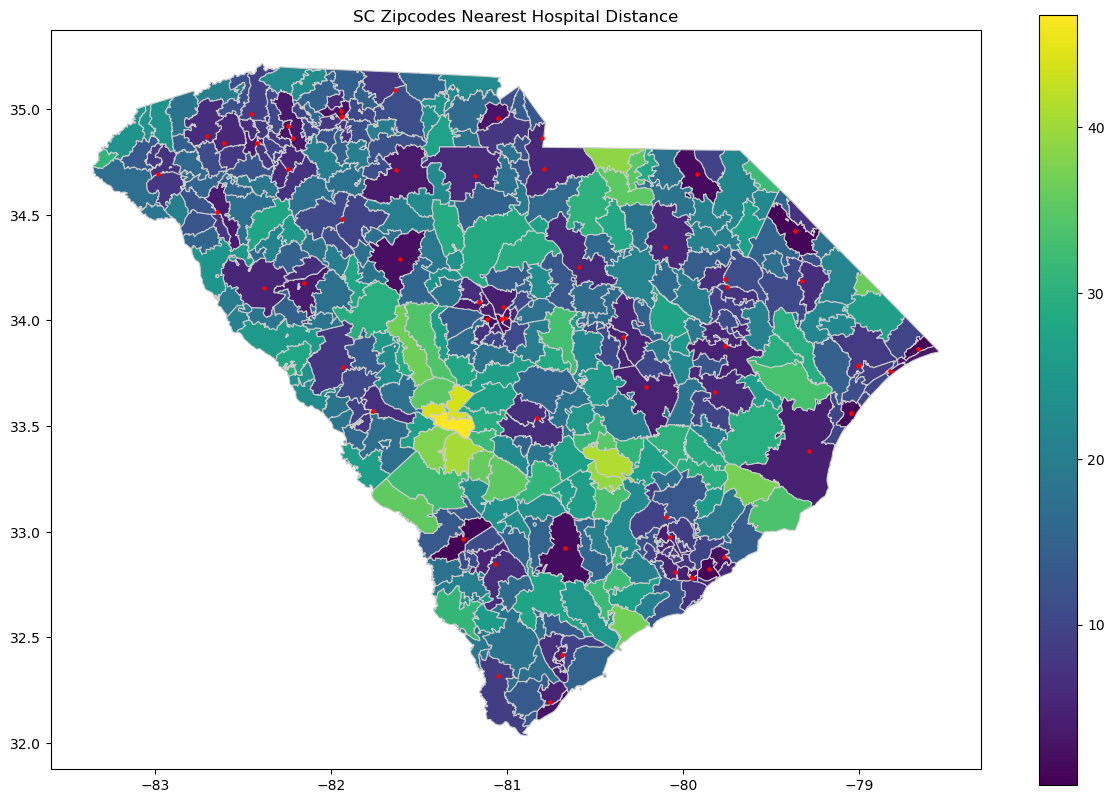

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_sc_zipcodes_and_hospitals(zipcodes_url, hospitals_url):
    sc_zipcodes = gpd.read_file(zipcodes_url)
    sc_hospitals = pd.read_csv(hospitals_url)
    sc_hospitals['geometry'] = sc_hospitals.apply(lambda row: Point(row['POINT_X'], row['POINT_Y']), axis=1)
    sc_hospitals = gpd.GeoDataFrame(sc_hospitals, crs="EPSG:4326")
    sc_zipcodes = sc_zipcodes.to_crs(sc_hospitals.crs)
    return sc_zipcodes, sc_hospitals

def calculate_distance_to_nearest_hospital(sc_zipcodes, sc_hospitals):
    nearest_distances = []
    for idx, zipcode_row in tqdm(sc_zipcodes.iterrows(), total=len(sc_zipcodes)):
        try:
            min_distance = np.inf
            for _, hospital_row in sc_hospitals.iterrows():
                distance = zipcode_row.geometry.centroid.distance(hospital_row.geometry)
                if distance < min_distance:
                    min_distance = distance
            nearest_distances.append(min_distance * 100)  # Convert degrees to kilometers, roughly 1 degree = 100 km
        except Exception as e:
            print(f"Error calculating distance for IDX {idx}: {e}")
            nearest_distances.append(np.nan)
    sc_zipcodes['nearest_hospital_distance'] = nearest_distances
    return sc_zipcodes

def plot_choropleth_map(sc_zipcodes, sc_hospitals):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    sc_zipcodes.plot(column='nearest_hospital_distance', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    sc_hospitals.plot(ax=ax, marker='o', color='red', markersize=5)
    ax.set_title("SC Zipcodes Nearest Hospital Distance")
    plt.show()

def main():
    zipcodes_url = "https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip"
    hospitals_url = "https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv"
    sc_zipcodes, sc_hospitals = load_sc_zipcodes_and_hospitals(zipcodes_url, hospitals_url)
    sc_zipcodes = calculate_distance_to_nearest_hospital(sc_zipcodes, sc_hospitals)
    plot_choropleth_map(sc_zipcodes, sc_hospitals)

if __name__ == "__main__":
    main()

In [82]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()
exec(solution.direct_request_code)
display(Code(solution.direct_request_code, language='python'))